# Data Exploration

#### Purpose: Initial data exploration and quality assessment

Author: Devbrew LLC

Created: 2025-10-01

Last Modified: 2025-10-01

## Notebook Configuration


#### Load packages and configure environment

In [ ]:
import warnings
from pathlib import Path
import json
from typing import Optional, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Environment configured successfully")
print(f"  - pandas: {pd.__version__}")
print(f"  - numpy: {np.__version__}")

✅ Environment configured successfully
  - pandas: 2.3.3
  - numpy: 2.3.3


### Path Configurations

Sets up project directory structure and validates data availability.

In [16]:
# Project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data_catalog"
PROCESSED_DIR = DATA_DIR / "processed"
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"

# Dataset paths
IEEE_CIS_DIR = DATA_DIR / "ieee-fraud" # IEEE-CIS Fraud Detection Dataset
PAYSIM_DIR = DATA_DIR / "paysim" # PaySim Dataset
OFAC_DIR = DATA_DIR / "ofac" # OFAC Sanctions Dataset

# Create output directiories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)


# Validate data availability
def validate_data_path() -> dict:
    """Validate that required datasets exists"""
    paths_status = {
        'IEEE Train Transaction': (IEEE_CIS_DIR / "train_transaction.csv").exists(),
        'IEEE Train Identity': (IEEE_CIS_DIR / "train_identity.csv").exists(),
        'IEEE Test Transaction': (IEEE_CIS_DIR / "test_transaction.csv").exists(),
        'IEEE Test Identity': (IEEE_CIS_DIR / "test_identity.csv").exists(),
        'PaySim': (PAYSIM_DIR / "PS_20174392719_1491204439457_log.csv").exists(),
        'OFAC SDN': (OFAC_DIR / "sdn" / "sdn.csv").exists(),
        'OFAC SDN ADD': (OFAC_DIR / "sdn" / "add.csv").exists(),
        'OFAC SDN ALT': (OFAC_DIR / "sdn" / "alt.csv").exists(),
        'OFAC SDN COMMENTS': (OFAC_DIR / "sdn" / "sdn_comments.csv").exists(),
        'OFAC Consolidated': (OFAC_DIR / "consolidated" / "cons_prim.csv").exists(),
        'OFAC Consolidated ADD': (OFAC_DIR / "consolidated" / "cons_add.csv").exists(),
        'OFAC Consolidated ALT': (OFAC_DIR / "consolidated" / "cons_alt.csv").exists(),
        'OFAC Consolidated COMMENTS': (OFAC_DIR / "consolidated" / "cons_comments.csv").exists(),
    }

    print("Data Availability Check:")
    print("-" * 60)
    for name, exists in paths_status.items():
        status = "✅" if exists else "❌"
        print(f"{name}: {status}")

    all_exist = all(paths_status.values())
    if not all_exist:
        print("\n⚠️  Warning: Some datasets are missing. Check data_catalog/README.md")
    else: 
        print("✅ All required datasets are found.")

    return paths_status    

paths_status = validate_data_path()


Data Availability Check:
------------------------------------------------------------
IEEE Train Transaction: ✅
IEEE Train Identity: ✅
IEEE Test Transaction: ✅
IEEE Test Identity: ✅
PaySim: ✅
OFAC SDN: ✅
OFAC SDN ADD: ✅
OFAC SDN ALT: ✅
OFAC SDN COMMENTS: ✅
OFAC Consolidated: ✅
OFAC Consolidated ADD: ✅
OFAC Consolidated ALT: ✅
OFAC Consolidated COMMENTS: ✅
✅ All required datasets are found.


## Helper Functions
Reusable utilities for data loading, analysis, and visualization.



In [ ]:
# Load dataset
def load_dataset(
    file_path: Path,
    nrows: Optional[int] = None,
    parse_dates: Optional[list] = None
) -> Optional[pd.DataFrame]:
    """
    Load CSV dataset with error handling and logging.

    Args:
        file_path: Path to CSV file
        nrows: Number of rows to load (None = all)
        parse_dates: Columns to parse as datetime
    
    Returns:
        Dataframe if successful, None if error

    Example:
        >>> df = load_dataset(IEEE_DIR / "train_transaction.csv", nrows=10000)
    """
    try:
        df = pd.read_csv(file_path, nrows=nrows, parse_dates=parse_dates)
        print(f"✅ Loaded dataset {file_path.name}")
        print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]:,} columns")
        print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        return df
    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {str(e)}")
        return None


# Analyze data quality
def analyze_data_quality(df: pd.DataFrame, name: str) -> dict:
    """
    Comprehensive data quality assessment.

    Args:
        df: DataFrame to analyze
        name: Dataset name for reporting

    Returns:
        Dictionary of quality metrics
    """
    print(f"\n{'=' * 70}")
    print(f"Data Quality Report: {name}")
    print(f"{'=' * 70}")
        

    # Basic info
    n_rows, n_cols = df.shape
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2

    print(f"\n📊 Dataset Overview:")
    print(f"  • Rows: {n_rows:,}")
    print(f"  • Columns: {n_cols}")
    print(f"  • Memory: {memory_mb:.2f} MB")

    # Data types
    print(f"\n📋 Column Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  • {dtype}: {count} columns")
    
    # Missing values
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100)
    missing_df = pd.DataFrame({
        'Count': missing[missing > 0],
        'Percent': missing_pct[missing > 0]
    }).sort_values('Percent', ascending=False)

    print(f"\nMissing Values:")
    if len(missing_df) > 0:
        print(f"  • Total missing values: {missing_df['Count'].sum():,}")
        print(f"  • Columns with missing values: {len(missing_df)}/{n_cols}")
        print(f"  • Top 5 missing columns:")
        for col, row in missing_df.head(5).iterrows():
            print(f" - {col}: {row['Count']:,} ({row['Percent']:.2f}%)")
    else:
        print("  • No missing values ✅")

    # Duplicate
    n_duplicates = df.duplicated().sum()
    dup_pct = (n_duplicates / len(df) * 100)
    print(f"\n🔄 Duplicates:")
    print(f"  • Duplicate rows: {n_duplicates:,} ({dup_pct:.2f}%)")

    # Return metrics for programmtic use
    return {
        'n_rows': n_rows,
        'n_cols': n_cols,
        'memory_mb': memory_mb,
        'missing_cols': len(missing_df),
        'missing_pct_max': missing_pct.max() if len(missing_pct) > 0 else 0,
        'n_duplicates': n_duplicates,
    }

# Analyze target variable
def analyze_target_variable(
    df: pd.DataFrame, 
    target_col: str, 
    title: str
) -> Tuple[float, dict]:
    """
    Analyze and visualize binary target variable.

    Args:
        df: DataFrame containing target
        target_col: Name of target column
        title: Plot title

    Returns:
        Tuple of (fraud_rate, metrics_dict)
    """
    # Calculate metrics
    total = len(df)
    fraud_count = df[target_col].sum()
    fraud_rate = (fraud_count / total) * 100
    imbalance_ratio = total / fraud_count if fraud_count > 0 else float('inf')

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Count plot
    counts = df[target_col].value_counts().sort_index()
    colors = ['#2ecc71', '#e74c3c'] # Green for legit, red for fraud
    counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', alpha=0.8)
    axes[0].set_title(f"{title} - Distribution", fontsize=12)
    axes[0].set_xlabel('Class (0=Legitimate, 1=Fraud)', fontsize=10)
    axes[0].set_ylabel('Count', fontsize=10)
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for i, v in enumerate(counts):
        axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')
    
    # Percentage pie chart
    axes[1].pie(
        counts, 
        labels=['Legitimate', 'Fraud'], 
        colors=colors,
        autopct='%1.2f%%', 
        startangle=90,
        explode=(0, 0.1), # Explode fraud slice
        shadow=True,
    )

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\n📈 Target Variable Analysis: {target_col}")
    print(f"  • Total transactions: {total:,}")
    print(f"  • Fraudulent: {fraud_count:,} ({fraud_rate:.2f}%)")
    print(f"  • Legitimate: {total - fraud_count:,} ({100 - fraud_rate:.2f}%)")
    print(f"  • Fraud rate: {fraud_rate:.2f}%")
    print(f"  • Class imbalance ratio: 1:{imbalance_ratio:.0f}")

    if fraud_rate < 1:
        print(f"  ⚠️  Highly imbalanced - consider SMOTE/undersampling")

    metrics = {
        'total': total,
        'fraud_count': fraud_count,
        'fraud_rate': fraud_rate,
        'imbalance_ratio': imbalance_ratio,
    }

    return fraud_rate, metrics        

In [28]:
# Test load_dataset
train_df = load_dataset(IEEE_CIS_DIR / "train_transaction.csv")

✅ Loaded dataset train_transaction.csv
Shape: 590,540 rows x 394 columns
Memory: 2100.70 MB


In [29]:
# Test analyze_data_quality
data_quality = analyze_data_quality(train_df, "train")
print(data_quality)


Data Quality Report: train

📊 Dataset Overview:
  • Rows: 590,540
  • Columns: 394
  • Memory: 2100.70 MB

📋 Column Types:
  • float64: 376 columns
  • object: 14 columns
  • int64: 4 columns

Missing Values:
  • Total missing values: 95,566,686
  • Columns with missing values: 374/394
  • Top 5 missing columns:
 - dist2: 552,913.0 (93.63%)
 - D7: 551,623.0 (93.41%)
 - D13: 528,588.0 (89.51%)
 - D14: 528,353.0 (89.47%)
 - D12: 525,823.0 (89.04%)

🔄 Duplicates:
  • Duplicate rows: 0 (0.00%)
{'n_rows': 590540, 'n_cols': 394, 'memory_mb': np.float64(2100.701410293579), 'missing_cols': 374, 'missing_pct_max': np.float64(93.62837403054831), 'n_duplicates': np.int64(0)}


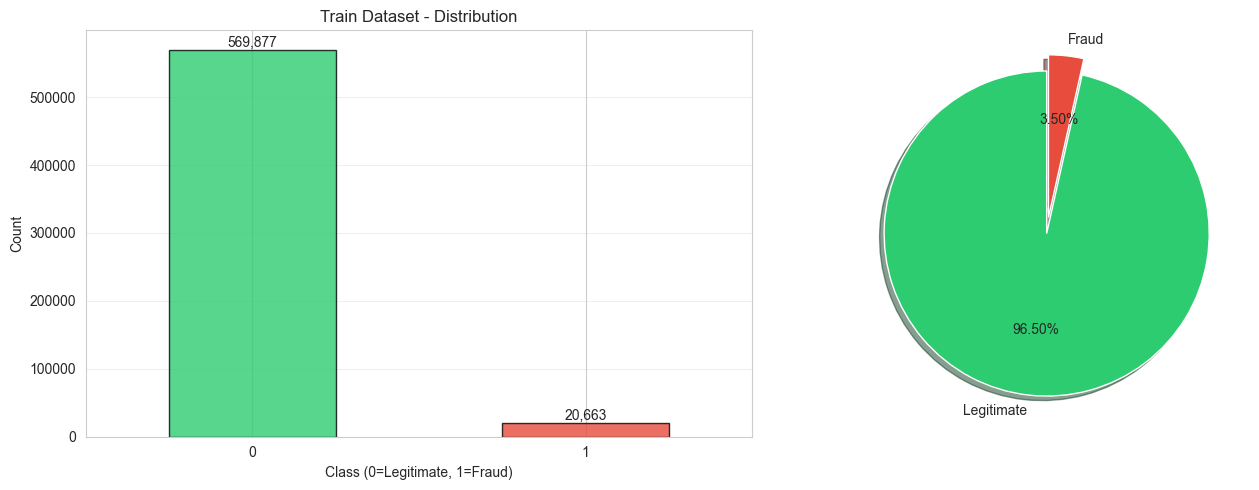


📈 Target Variable Analysis: isFraud
  • Total transactions: 590,540
  • Fraudulent: 20,663 (3.50%)
  • Legitimate: 569,877 (96.50%)
  • Fraud rate: 3.50%
  • Class imbalance ratio: 1:29


(np.float64(3.4990009144173126),
 {'total': 590540,
  'fraud_count': np.int64(20663),
  'fraud_rate': np.float64(3.4990009144173126),
  'imbalance_ratio': np.float64(28.579586700866283)})

In [44]:
# Test data visualization
analyze_target_variable(train_df, 'isFraud', 'Train Dataset')
